# W207 Spring 2019 Final Project
## Kaggle Competition: Forest Cover Prediction
**Pierce Coggins, Jake Mitchell, Debasish Mukhopadhyay, and Tim Slade**

# Table of Contents/Section Notes

- [Introduction](#introduction)
- [Housekeeping](#housekeeping)
  - [Importing Libraries and Helper Functions](#import)
  - [Splitting Data into Train and Test Sets](#splittingData)
- [About the Data](#aboutTheData)
  - [Initial Exploration of the Challenge](#summary)
  - [Where do we start?](#exploratoryDataAnalysis)
  - [Cleaning the Data](#dataCleaning)
- [Feature Engineering](#featureEngineering)
  - Describe a basic model that we will use to test the usefulness of new features (LR or NB)
  - Normalization
  - Review each added or removed feature
- [Models](#models)
  - [Logistic Regression](#logistic)
  - 
- [Error Analysis]
  - Summary and remediation of errors in model
- [Results](#results)
  - What went well, what went poorly
  - Final comparison of models on test data
- [Conclusion](#conclusion)
- [Annexes](#annexA)
  

<a id="introduction"></a>
# Introduction

In this report, our objective is to predict the forest cover type (defined as the predominant type of tree cover) for an area of land in Colorado given only cartographic input variables.  This problem and dataset was initially posted on Kaggle in 2015.  We have elected to take on this problem as it uniquely allows for various machine learning techniques to be applied.  This report provides a detailed explanation of our methodology from data exploration through to model creation and evaluation.

The problem of understanding what type of vegetation is present in a given area of wilderness is surprisingly important.  In this example we are exploring the forests of Colorado, which are home to a diverse set of trees each with their own enviornmental benefits and vulnerabilities.  For example, many of the pine trees in Colorado are susceptible to the [mountain pine beetle](https://csfs.colostate.edu/forest-management/common-forest-insects-diseases/mountain-pine-beetle/), while Spruce and Fir trees are much less suceptible.  Without manually surveying thousands of miles of wilderness, it is very difficult to distinguish these types of trees from one another as they look very similar from the air.  However, it is relatively easy to get cartographic data for larger wilderness areas. Given that this is the challenge at hand, if it were possible to accurately predict the predominant forest cover type from cartographic data then all Colorado forests could be mapped using this method. That information would be invaluable to firefighters and forest service personnel to direct their resources to the areas of wilderness that may be more vulnerable to certain pests or environmental hazards.

If you would like to learn more about the problem or try for yourself, all information and data can be found within the kaggle competition:<br>[Kaggle's Forest Cover Type Prediction](https://www.kaggle.com/c/forest-cover-type-prediction).

<a id="housekeeping"></a>
## Housekeeping

<a id="import"></a>
### Importing Libraries, Helper Functions, and Loading Data

In [1]:
%%capture
# %matplotlib inline
# %matplotlib notebook
%matplotlib qt

# General libraries
import pandas as pd
import numpy as np
import os
import copy
import warnings
import statsmodels.api as sm
from scipy import stats
import math

# Plotting and printing libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import pprint

# Model-building libraries
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import normalize, MinMaxScaler, StandardScaler, RobustScaler, Normalizer, scale

# SK-learn libraries for learning
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import BernoulliNB, GaussianNB, MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# SK-learn libraries for evaluation
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import hamming_loss
import itertools

import warnings
warnings.filterwarnings('ignore')

# Run the helper functions notebook
%run w207_final_helper_functions.ipynb

<a id="splittingData"></a>
### Splitting Data into Train and Test Sets

In our dataset, the forest cover types we aim to predict are included with the features we plan to use to predict them. Our first step is to separate our input variables from our output variable. We also want to split the dataset into _train_ and _test_ subsets; this will give us insight into how well our chosen models and parameters will perform against out-of-sample data.

The original dataset contained 15,120 observations. We will train our models on 90% of the data and hold out 10% for testing. We thus expect to have approximately 13,608 observations in our training set.

In [2]:
%%capture --no-stdout --no-display
full_data = pd.DataFrame.from_csv('./train.csv')
full_data.shape

# Separating out the labels
full_labels = full_data['Cover_Type']
full_features = full_data.drop('Cover_Type', axis=1)

# Setting seed so we get consistent results from our splitting
np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(full_features, full_labels, test_size=0.10)

# Verifying our data shapes are as expected
print(f'''
{'':^16} | {'Observations':^12} | {'Features':^10} |
{'-'*46}
{'Training dataset':^16} | {X_train.shape[0]:^12} | {X_train.shape[1]:^10} |
{'Training labels':^16} | {y_train.shape[0]:^12} | {'--':^10} |
{'Test dataset':^16} | {X_test.shape[0]:^12} | {X_test.shape[1]:^10} |
{'Test labels':^16} | {y_test.shape[0]:^12} | {'--':^10} |
''')


                 | Observations |  Features  |
----------------------------------------------
Training dataset |    13608     |     54     |
Training labels  |    13608     |     --     |
  Test dataset   |     1512     |     54     |
  Test labels    |     1512     |     --     |



<a id="aboutTheData"></a>

<a id="aboutTheData"></a>
# About the Data

The data comes from several wilderness areas in northern Colorado, specifically the Rawah Wilderness Area, Neota Wilderness Area, Comanche Peak Wilderness Area and the Cache la Poudre Wilderness Area.  These are all fairly remote areas of Colorado, which is likely why they were chosen; there is unlikely to be evidence of human influence in these regions, simplifying our prediction task.

The features in the dataset are all cartographic measures of a 30x30m square plot of land.  We have 10 simple features. The 11th and 12th - `wilderness_area` and `soil_type` - are categorical variables comprised of 4 and 40 dummy variables respectively. We therefore have a total of 54 features to work with.
The list below contains a short description of each feature, including its range, median, and mean when relevant. (See [Annex A](#annexA) for the associated code and further discussion of the exploratory data analysis).

- `Elevation`: _Elevation in meters_
  - **Range**: 1863 to 3849 | **Mean**: 2749.3 | **Median**: 2752


- `Aspect`: _Aspect in degrees azimuth. i.e., degrees clockwise from a line pointed at true North. So North = 0$^\circ$, East = 90$^\circ$, South = 180$^\circ$, and West = 270$^\circ$_
  - **Range**: 0 to 360 | **Mean**: 156.7 | **Median**: 126.0


- `Slope`: _Slope in degrees. 0$^\circ$ would indicate a flat plane; greater values represent steeper slopes._
  - **Range**: 0 to 52 | **Mean**: 16.5 | **Median**: 15.0 


- `Horizontal_Distance_To_Hydrology`: _Horizontal distance to nearest surface water features. Units unspecified._
  - **Range**: 0 to 1343 | **Mean**: 227.2 | **Median**: 180 


- `Vertical_Distance_To_Hydrology`: _Vertical distance to nearest surface water features. Units unspecified._
  - **Range**: -146 to 554 | **Mean**: 51.1 | **Median**: 32.0


- `Horizontal_Distance_To_Roadways`: _Horizontal distance to nearest roadway. Units unspecified._
  - **Range**: 0 to 6890 | **Mean**: 1714.0 | **Median**: 1316


- `Hillshade_9am`: _(0 to 255 index) - Hillshade index at 9am, summer solstice_
  - **Range**: 0 to 254 | **Mean**: 212.7 | **Median**: 220


- `Hillshade_Noon`: _(0 to 255 index) - Hillshade index at noon, summer solstice_
  - **Range**: 99 to 254 | **Mean**: 219.0 | **Median**: 223


- `Hillshade_3pm`: _(0 to 255 index) - Hillshade index at 3pm, summer solstice_
  - **Range**: 0 to 248 | **Mean**: 135.1 | **Median**: 138.0


- `Horizontal_Distance_To_Fire_Points`: _Horizontal distance to nearest wildfire ignition points. Units unspecified._
  - **Range**: 0 to 6993 | **Mean**: 1511.2 | **Median**: 1256 


- `Wilderness_Area`: _(4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation_
  - % of cases - **Area 1**: 24% || **Area 2**: 3% || **Area 3**: 42% || **Area 4**: 31% 


- `Soil_Type`: _(40 binary columns, 0 = absence or 1 = presence) - Soil type designation_
  - The soil types descriptions can be found at the [Kaggle Competition Data Page](https://www.kaggle.com/c/forest-cover-type-prediction/data)

<a id="summary" > </a>
### Initial Exploration of the Challenge
The categorical label we are trying to predict is contained in the `Cover_Type` variable, and is split up into 7  designations. While the tree species discussed in the Colorado State Forest Service's [_Colorado's Major Tree Species_](https://csfs.colostate.edu/colorado-trees/colorados-major-tree-species/) article do not map perfectly to these categories, the article provides some context that may prove useful.

#### <span style='color:blue'>Category 1</span>: 'Spruce/Fir'
- Species that might fit into this category include the **Blue Spruce** (which thrives at an altitude of 6700-11500 ft in sandy soils near moisture), the **Engelmann Spruce** (8000-11000 ft, moist north-facing slopes), the **Subalpine Fir** (8000-12000 ft, cold high-elevation forests), and the **White Fir** (7900-10200 ft, moist soils in valleys).

<center>Blue Spruce</center> | <center>Engelmann Spruce</center> | <center>Subalpine Fir</center> | <center>White Fir</center>
- | - | - | -
<img src="imgs/1_blue-spruce-tree.jpg" alt="BlueSpruce" style="width: 250px;"/>  | <img src="imgs/1_engelmann-spruce.jpg" alt="EngelmannSpruce" style="width: 250px;"/> | <img src="imgs/1_subalpine-fir.jpg" alt="SubalpineFir" style="width: 250px;"/> | <img src="imgs/1_white-fir-tree.jpg" alt="WhiteFir" style="width: 250px;"/>

#### <span style='color:blue'>Category 2</span>: 'Lodgepole Pine' and <span style='color:blue'>Category 3</span>: 'Ponderosa Pine'
- The **Lodgepole Pine** thrives in well-drained soils at high elevations (6000-11000 ft).
- The **Ponderosa Pine** thrives in dry, nutrient-poor soils at elevations of 6300-9500 ft. It is often found with Douglas Firs.

<center>Lodgepole Pine</center> | <center>Ponderosa Pine</center> |
- |-|
<img src="imgs/2_lodgepole-pine.jpg" alt="LodgepolePine" style="width: 250px;"/> | <img src="imgs/3_ponderosa-pine.jpg" alt="PonderosaPine" style="width: 250px;"/> |

#### <span style='color:blue'>Category 4</span>: 'Cottonwood/Willow'
- This category includes the **Plains Cottonwood** (which thrives at altitudes of 3500-6500 ft near sources of water), the **Narrowleaf Cottonwood** (5000-8000 ft, moist soils along streams), and the **Peachleaf Willow** (3500-7500 ft, near water sources).

<center>Plains Cottonwood</center> | <center>Narrowleaf Cottonwood</center> | <center>Peachleaf Willow</center> |
- |- |- |
<img src="imgs/4_plains-cottonwood.jpg" alt="PlainsCottonwood" style="width: 250px;"/> |<img src="imgs/4_narrowleaf-cottonwood.jpg" alt="NarrowleafCottonwood" style="width: 250px;"/> |<img src="imgs/4_peachleaf-willow.jpg" alt="PeachleafWillow" style="width: 250px;"/> |

#### <span style='color:blue'>Category 5</span>: 'Aspen' and <span style='color:blue'>Category 6</span>: 'Douglas Fir'
- The **Quaking Aspen** thrives at altitudes of 6500-11500 ft. While it can be in many soil types, it is most often found on sandy and gravelly slopes.
- The **Douglas Fir** thrives at altitudes of 6000-9500 ft and thrives in rocky soils and moist northern facing slopes.

<center>Quaking Aspen</center> | <center>Douglas Fir</center> |
- | - |
<img src="imgs/5_aspen.jpg" alt="QuakingAspen" style="width: 250px;"/> | <img src="imgs/6_douglas-fir.jpg" alt="DouglasFir" style="width: 250px;"/>|

#### <span style='color:blue'>Category 7</span>: 'Krummholz'
- Interestingly, _krummholz_ is not a species of tree; it is a type of tree formation (which can emerge across various tree species) that results from long-term wind exposure, often strong and cold winds. Per [Wikipedia](https://en.wikipedia.org/wiki/Krummholz), Subalpine Fir and Engelmann Spruce are often associated with Krummholz conditions (as is Lodgepole Pine, although that is more common in British Columbia). This category, while not specific to a species may be a better indication of a certain subset of environmental vulnerabilies than species alone.

<center>Krummholz Banner Tree</center> | <center>Krummholz White Pine</center> | <center>Krummholz Bristlecone</center> 
- |- |- |
<img src="imgs/7_krummholz-banner-tree.jpg" alt="KrummholzBannerTree (Photo credit to John Spooner - flickr.com, CC BY 2.0, https://commons.wikimedia.org/w/index.php?curid=5007578)" style="width: 250px;"/> | <img src="imgs/7_krummholz-white-pine.jpg" alt="KrummholzWhitePine (Photo credit to Walter Siegmund [CC BY-SA 3.0 (https://creativecommons.org/licenses/by-sa/3.0)] https://commons.wikimedia.org/wiki/File:Pinus_albicaulis_7872.JPG" style="width: 350px;"/> |  <img src="imgs/7_krummholz-windswept-bristlecone.jpg" alt="KrummholzBristlecone" style="width: 400px;"/> | 


<a id="exploratoryDataAnlysis"> </a>
### Where do we start?

The brief descriptions we've seen already suggest some avenues of exploration: elevation and hydrology seem to be of primary importance.

#### What can we learn from elevation alone?

We will start by visualizing the elevation ranges across the various tree species mentioned above. We expect elevation to be important as it is the primary indicator of environmental conditions in mountainous regions. The graph below illustrates the ranges in which the species of trees discussed the Colorado State Forest Service's [_Colorado's Major Tree Species_](https://csfs.colostate.edu/colorado-trees/colorados-major-tree-species/) are most commonly found.

<img src="imgs/altitudeRanges4.png" alt="ElevationRangesIdealized" style="width: 800px;"/>

It appears that lower elevations would be strongly suggestive of `Cottonwood/Willow`, while higher elevations might be more suggestive of the `Spruce/Fir`, `Lodgepole Pine`, `Aspen`, and `Krummholz`. The graph above is based upon data aggregated from outside sources. It's important that we verify this against our actual dataset, as it may indicate otherwise. The graphs below present the observed _elevation_ ranges and quartiles by `Cover_Type` in our data.

| <center>Elevation Ranges</center> | <center>Elevation Quartiles</center>
|-|-
|<img src="imgs/elevationRanges.png" alt="ElevationRanges" style="width: 600px;"/> |<img src="imgs/elevationQuartiles.png" alt="ElevationQuartiles" style="width: 600px;"/> |

When looking at the ranges, our dataset appears to differ from our initial visualization in that the `Cottonwood/Willow` `Cover_Type` does not seem to occur at markedly lower elevations. However, when looking at the quartiles, patterns emerge that appear similar to what we would expect from our initial visualization: `Cottonwood/Willow` tends to cluster at lower elevations, with the higher elevations dominated by `Spruce/Fir` and `Krummholz` cover types.

The separations are surprisingly clean, suggesting that `Elevation` will be a powerful feature in our models. It might be especially powerful if we could develop a method to cluster the altitudes based on interquartile ranges presented above.

<a id="ref1"> </a>
#### What if we bring water into the picture?
The other feature that the article suggests might be highly salient is moisture. How does the picture evolve if we add a measure of distance to water?

The graph below is a scatterplot of the Euclidean distance (derived from the `Horizontal_Distance_To_Hydrology` and `Vertical_Distance_To_Hydrology` features) and the `Elevation`, with data points colored by the `Cover_Type`.

<img src="imgs/hydrologyAndElevationScatter.png" alt="HydrologyAndElevationScatter" style="width: 600px;"/>

The distance to hydrology appears to be informative: `Cover_Type`s 3, 4, and 6 are essentially not found when the distance to water exceeds 750. That said, distance to hydrology is likely correlated with our primary distinguishing feature, `Elevation`.

#### What if we consider exposure to sunlight and wind?
Intuitively, the amount of sunlight to which a given plot of land is exposed would likely influence the predominant forest cover type. In our dataset, the `Hillshade` variables is likely to contain this information.

The plot below compares the 1st quartile, median, and 3rd quartiles for each measure of `Hillshade` and each category of `Cover_Type`.

<img src="imgs/hillshadeQuartiles.png" alt="HillshadeQuartiles" style="width: 600px;"/>

While the median `Hillshade` values appear to vary slightly across categories in the morning and afternoon, the interquartile range is overlapping across categories. The main takeaway from this is that `Hillshade` is unlikely to be a strong indicator of `Cover_Type` on its own.

Exposure to sunlight and wind would also be affected by the `Aspect` variable, which can most easily be understood as the cardinal direction a given slope of land is facing (0$^\circ$ is true North, 90$^\circ$ is due East, 180$^\circ$ is South, 270$^\circ$ is due West). While the exact nature of the interaction between these features may not be clear *a priori*, we can attempt to collapse the effect into a single feature by taking the first principal component of the `Hillshade_9am` and `Hillshade_3pm` features with the `Aspect` feature.

The graph below plots this first principal component against `Elevation`, since we already know `Elevation` is likely our most informative input variable.

<img src="imgs/hillshadeAspectPcaScatter.png" alt="hillshadeAspectPcaScatter" style="width: 600px;"/>

What patterns we see are weak at best. While the `Douglas Fir` category appears to be more prevalent for greater and lesser values of this first principal component, and the `Ponderosa Pine` appears to be slightly more prevalent nearer to zero, it is clear that the `Elevation` remains the dominant feature.

#### What about the 'Kitchen Sink' approach?

So far we've examined `Elevation`, `Hydrology`, `Aspect`, and `Hillshade` features on the basis of the Colorado State Forestry write-up, but we should also take a more comprehensive look at all of our input variables and how they might be interacting with one another in ways not captured in our initial research.

The graph below is a scatterplot matrix incorporating all of the raw simple features in our dataset, as well as the `Euclidean_Distance_To_Hydrology` feature we composed from the horizontal and vertical distances to hydrology.

<img src="imgs/scatterplotMatrixElevationAspectWaterHillshade.png" alt="scatterplotMatrixElevationAspectWaterHillshade" style="width: 800px;"/>

While `Elevation` remains the feature that provides the cleanest separation between `Cover_Type`s, two additional features (`Horizontal_Distance_To_Roadways` and `Horizontal_Distance_To_Fire_Points`) perform notably well when identifying the `Lodgepole Pine` specifically.

<a id="dataCleaning"> </a>
### Cleaning the Data
While exploring the data (see [Annex A](#annexA)), we noticed that `Soil_Type7` and `Soil_Type15` variables are always false. Because there is no information gained from these features, it contributes nothing to our dataset and will not have any impact on our models.

Additionally, we noticed the `Hillshade_9am` and `Hillshade_3pm` features are missing several values.  We choose to replace these values with the median value for those features.  This will allow the areas with missing values to be more accurately classified as they no longer have un-usable data.

In [3]:
engineered_features = pd.DataFrame.copy(full_features)

# Removing uninformative features
engineered_features = engineered_features.drop(['Soil_Type7', 'Soil_Type15'], axis=1)

# Replacing Hillshade_9am and Hillshade_3pm 0 values with median
median_hillshade_9am = np.median(engineered_features['Hillshade_9am'])
engineered_features['Hillshade_9am'] = engineered_features.apply(lambda row: median_hillshade_9am if row.Hillshade_9am == 0 else row.Hillshade_9am, axis=1)
median_hillshade_3pm = np.median(engineered_features['Hillshade_3pm'])
engineered_features['Hillshade_3pm'] = engineered_features.apply(lambda row: median_hillshade_3pm if row.Hillshade_3pm == 0 else row.Hillshade_3pm, axis=1)


<a id="featureEngineering"></a>
# Feature Engineering

Successful machine learning projects often depend heavily on feature engineering. The most important feature in a dataset may be a latent one - that is, 'hidden' behind other features which serves as proxies for it. In such a case, the latent feature needs to be explicitly extracted. While we are exploring the potential of various synthetic/constructed features, we will also try to remove original features which prove to be uninformative. Doing so will reduce the noise passed into our models and help to isolate only the most important features. We will keep our engineered and source datasets separate by creating a deep copy of the data.

### Euclidean Distance to Hydrology

As we saw in our [Exploratory Data Analysis](#ref1), the `Cover_Type` can be visually broken up based on their distance to hydrology, both horizontally and vertically.  By combining these features into a single feature, we can reduce the overall number of features without much loss of information.

### Elevation of Hydrology

Elevation and Hydrology are very important features when it comes to predicting the `Cover_Type` of an area.  By subtracting the vertical distance to hydrology from the elevation, we can identify the elevation of the hydrology itself.  This may prove useful by providing a feature that would be able to distinguish between an alpine lake and a valley stream.

### Mean Distance to Feature

As we saw in our [Exploratory Data Analysis](#aboutTheData), distance metrics group the data pretty well for classification.  With this we can engineer a new feature that incorporates the mean distance to hydrology, fire points, and roadways. While distance to hydrology was a strong indicator, the latter two features provide a fair approximation of the remoteness of the area.

### Stony

This data set features 40 different types of soils.  When compared to the 7 possible labels, this number of soil types seems a bit extreme.  Different types of trees favor more rocky soils, and so combining all of the stony soil types into a single feature will allow a model to more easily pick up on that.

### Hillshade

In [4]:
full_features[['Hillshade_9am', 'Hillshade_3pm']].describe()

,Hillshade_9am,Hillshade_3pm
count,15120.000000,15120.000000
mean,212.704299,135.091997
std,30.561287,45.895189
min,0.000000,0.000000
25%,196.000000,106.000000
50%,220.000000,138.000000
75%,235.000000,167.000000
max,254.000000,248.000000


In [5]:
engineered_features['Euclidean_Distance_To_Hydrology'] = engineered_features.apply(lambda row: math.sqrt(row.Horizontal_Distance_To_Hydrology**2 + row.Vertical_Distance_To_Hydrology**2), axis=1)
engineered_features['Elevation_Of_Hydrology'] = engineered_features['Elevation']-engineered_features['Vertical_Distance_To_Hydrology']
engineered_features['Mean_Distance_To_Feature'] = (engineered_features['Horizontal_Distance_To_Hydrology']+engineered_features['Horizontal_Distance_To_Roadways']+engineered_features['Horizontal_Distance_To_Fire_Points'])/3
engineered_features['Stony'] = engineered_features[['Soil_Type1', 'Soil_Type2', 'Soil_Type6', 'Soil_Type9', 'Soil_Type12', 'Soil_Type18', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40', ]].any(axis=1)

np.random.seed(0)
e_X_train, e_X_test, e_y_train, e_y_test = train_test_split(engineered_features, full_labels, test_size=0.10)

### How to Test Feature Changes

Without _a priori_ knowledge of how the interplay between soil types, topography, hydrology, etc. affects forest cover, we need a way to view the performance of new features.  As such we will use a simple Gaussian Naive Bayes model to do predictions, and quanitify the results using cross-validation.  We will be tracking performance across precision, recall, and f1-score.

#### Naïve Bayes

One reasonable place to begin might be a Naïve Bayes classifier. While it is unlikely that all of the features at our disposal are _strictly_ independent, we may be able to relax the assumption of independence enough to explore how a NB model performs.

We don't want a Bernoulli NB model as our features do not take on binary values exclusively. We also don't want a Multinomial NB model as it assumes integer feature counts. A Gaussian NB, on the other hand, might work well. While it assumes that the likelihoods of the features are Gaussian - and this is not necessarily strictly the case - it may be worth trying.

In [6]:
# Testing on the base data
cross_validate_model(GaussianNB(), X_train, y_train, name='Base Data GaussianNB', verbose=True)

# Testing on the engineered data
cross_validate_model(GaussianNB(), e_X_train, e_y_train, name='Base Data GaussianNB', verbose=True)

Model: Base Data GaussianNB, with 5 folds
			Spruce/Fir           | precision:  0.72 | recall:  0.50 | f1-score:  0.59 | 
			Lodgepole Pine       | precision:  0.13 | recall:  0.73 | f1-score:  0.22 | 
			Ponderosa Pine       | precision:  0.73 | recall:  0.43 | f1-score:  0.54 | 
			Cottonwood/Willow    | precision:  0.92 | recall:  0.68 | f1-score:  0.78 | 
			Aspen                | precision:  0.73 | recall:  0.59 | f1-score:  0.65 | 
			Douglas Fir          | precision:  0.07 | recall:  0.77 | f1-score:  0.12 | 
			Krummholz            | precision:  0.82 | recall:  0.86 | f1-score:  0.84 | 
			macro avg            | precision:  0.59 | recall:  0.65 | f1-score:  0.54 | 
			micro avg            | precision:  0.59 | recall:  0.59 | f1-score:  0.59 | 
			weighted avg         | precision:  0.76 | recall:  0.59 | f1-score:  0.65 | 

Model: Base Data GaussianNB, with 5 folds
			Spruce/Fir           | precision:  0.73 | recall:  0.53 | f1-score:  0.61 | 
			Lodgepole Pine       | precision

{'micro avg': {'precision': [0.6097650513950074,
   0.6043350477590007,
   0.6119073869900772,
   0.6181550900404263,
   0.6077205882352941],
  'recall': [0.6097650513950074,
   0.6043350477590007,
   0.6119073869900772,
   0.6181550900404263,
   0.6077205882352941],
  'f1-score': [0.6097650513950074,
   0.6043350477590007,
   0.6119073869900772,
   0.6181550900404263,
   0.6077205882352941]},
 'macro avg': {'precision': [0.6090577885167442,
   0.6038886965428497,
   0.6110345186273084,
   0.6173383533745467,
   0.6067011645656413],
  'recall': [0.6685745052872445,
   0.6642749912992298,
   0.6573826095460766,
   0.6844580165295616,
   0.6444386585639031],
  'f1-score': [0.5524266759576272,
   0.5567692471370849,
   0.5541457197707321,
   0.5657936734483023,
   0.5537158291731167]},
 'weighted avg': {'precision': [0.7780552955877454,
   0.7551670888931815,
   0.7763081799756854,
   0.7778886789950984,
   0.7670171204434715],
  'recall': [0.6097650513950074,
   0.6043350477590007,
   0.

In this report we will use two metrics to determine how well a particular model performs, precision and recall.  All in all, just throwing a Gaussian Naive Bayes classifier at the data performed better than expected.  It achieved a 76% weighted precision across 5 fold cross validation.  

The engineered features do not provide as much improvement as we had initially hoped.  They resulted in 1-2% improvement across all of the feature engineering mentioned above.  It may be worth noting that the engineered features improved classification of categories that had worse performance more than those that were already well classified.

### Failed Engineered Features

Not every feature that is engineered is a useful addition to the data set.  Randomly adding new features can add unnecessary noise to the dataset without add any new information.  We have listed the failed features below.  Some highlights include mountain width and prominence (from the `Elevation` and `Slope` features), and a few different ways to view the elevation of an area.

In [7]:
# engineered_features['Elevation_Away_From_Hydrology'] = engineered_features['Elevation']-engineered_features['Horizontal_Distance_To_Hydrology']
# engineered_features['Mountain_Width'] = engineered_features.apply(lambda row: row.Elevation/math.tan(math.radians(row.Slope+.1)), axis=1)
# engineered_features['Mountain_Prominence'] = engineered_features.apply(lambda row: row.Elevation/math.sin(math.radians(row.Slope+.1)), axis=1)
# engineered_features['Mean_Hillshade'] = engineered_features.apply(lambda row: (row.Hillshade_9am + row.Hillshade_Noon + row.Hillshade_3pm)/3, axis=1)
# engineered_features['Morning_Hillshade'] = engineered_features.apply(lambda row: (row.Hillshade_9am * row.Hillshade_Noon), axis=1)
# engineered_features['Norm_Horizontal_Distance_To_Hydrology'] = engineered_features['Horizontal_Distance_To_Hydrology']/(np.mean(engineered_features['Horizontal_Distance_To_Hydrology']))
# engineered_features['Norm_Elevation'] = engineered_features['Elevation']/(np.mean(engineered_features['Elevation']))
# engineered_features['Log_Elevation'] = engineered_features.apply(lambda row: math.log(row.Elevation), axis=1)

### Standardization of the Features

Standardization is a very important aspect of preparing data for consumption by machine learning models.  It brings all of the features into a standardized range, preventing our models from haivng bias toward certain features on the basis of relative scale. By ensuring all features are kept within a standardized range, we eliminate the possibility that certain features could dominate the weighting and prediction process simply by virtue of being represented on a larger scale than that another potentially more meaningful feature.  We will experiment with several different types of standardization to see which is the most effective. Specifically we will test Min-Max scaling, standard scaling, robust scaling and sklearn's normalizer.

#### Evaluating standardization using K-Nearest Neighbors

One issue with Naïve Bayes models is that they are more or less invariant to feature scaling, and therefore cannot be used when testing standardization methods.  For this reason, We will use the `KNearestClassifier` with *K = 3* when testing our performance on scaled data.  In testing a variety of values for `K`, we found that *K = 3* consistently produced the best results.

In [8]:
# Testing on the unscaled data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), e_X_train, e_y_train, name='3 Nearest Neighbors', verbose=True)

Model: 3 Nearest Neighbors, with 5 folds
			Spruce/Fir           | precision:  0.66 | recall:  0.74 | f1-score:  0.70 | 
			Lodgepole Pine       | precision:  0.58 | recall:  0.71 | f1-score:  0.64 | 
			Ponderosa Pine       | precision:  0.74 | recall:  0.83 | f1-score:  0.78 | 
			Cottonwood/Willow    | precision:  0.96 | recall:  0.90 | f1-score:  0.93 | 
			Aspen                | precision:  0.96 | recall:  0.83 | f1-score:  0.89 | 
			Douglas Fir          | precision:  0.85 | recall:  0.80 | f1-score:  0.82 | 
			Krummholz            | precision:  0.97 | recall:  0.88 | f1-score:  0.92 | 
			macro avg            | precision:  0.82 | recall:  0.81 | f1-score:  0.81 | 
			micro avg            | precision:  0.82 | recall:  0.82 | f1-score:  0.82 | 
			weighted avg         | precision:  0.84 | recall:  0.82 | f1-score:  0.82 | 



{'micro avg': {'precision': [0.8146108663729809,
   0.8163115356355621,
   0.8254318265343623,
   0.8191841234840133,
   0.8202205882352941],
  'recall': [0.8146108663729809,
   0.8163115356355621,
   0.8254318265343623,
   0.8191841234840133,
   0.8202205882352941],
  'f1-score': [0.8146108663729809,
   0.8163115356355621,
   0.8254318265343623,
   0.8191841234840133,
   0.820220588235294]},
 'macro avg': {'precision': [0.8141770596219742,
   0.8159253030286421,
   0.8251051344250694,
   0.8187954497324702,
   0.8197059545706705],
  'recall': [0.8087347268970901,
   0.8091930247989838,
   0.8203685045861402,
   0.8132360728902636,
   0.8149474773899618],
  'f1-score': [0.8087073016186962,
   0.8078934062593393,
   0.8209311009973556,
   0.8136062365169338,
   0.8143538157561508]},
 'weighted avg': {'precision': [0.8311696995944909,
   0.8414566359132629,
   0.837412171461308,
   0.8343643116850249,
   0.8371072453803706],
  'recall': [0.8146108663729809,
   0.8163115356355621,
   0.82

The `KNearestClassifier` performed remarkably well on the base data with 84% precision and 82% recall.  This is a surprisingly good result for an out-of-the-box model.  However with such a low K, we would need to run this against a larger test set to ensure we aren't overfitting.

#### Standardization Performance

We tested standardization using each of the following methods:
+ `MinMaxScaler` with ranges of [-1, 1] and [0, 1]
+ `StandardScaler` with the range [0, 1]
+ `RobustScaler`
+ `Normalizer`


In [9]:
%%capture
mm_neg1_1_scaled_df = apply_scaler(MinMaxScaler(feature_range=(-1, 1)), e_X_train)
print("MinMaxScaler [-1,1]")
mm_neg1_1_scaled_df.head(5)

mm_0_1_scaled_df = apply_scaler(MinMaxScaler(feature_range=(0, 1)), e_X_train)
print("MinMaxScaler [0,1]")
mm_0_1_scaled_df.head(5)

standard_scaled_df = apply_scaler(StandardScaler(), e_X_train)
print("StandardScaler [0,1]")
standard_scaled_df.head(5)

r_scaled_df = apply_scaler(RobustScaler(), e_X_train)
print("RobustScaler [0,1]")
r_scaled_df.head(5)

n_scaled_df = apply_scaler(Normalizer(), e_X_train)
print(n_scaled_df.shape)
n_scaled_df.head(10)

The code block above demonstrates the effect of applying each of these methods. (Removing the `%%capture` line will allow the output to be generated.) Output is currently omitted for simplicity sake. 

In [10]:
# Testing on the [-1,1] scaled data again for reference
cross_validate_model(KNeighborsClassifier(n_neighbors=3), mm_neg1_1_scaled_df, e_y_train, name='3 Nearest Neighbors, MinMax scaled [-1,1]')
# Testing on the [0,1] scaled data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), mm_0_1_scaled_df, e_y_train, name='3 Nearest Neighbors, MinMax scaled [0,1]')
# Testing on the [0,1] scaled data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), standard_scaled_df, e_y_train, name='3 Nearest Neighbors, Standard scaled [0,1]')
# Testing on the Robust scaled data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), r_scaled_df, e_y_train, name='3 Nearest Neighbors, Robust scaled [0,1]')
# Testing on the Normalized data
cross_validate_model(KNeighborsClassifier(n_neighbors=3), n_scaled_df, e_y_train, name='3 Nearest Neighbors, Normalized')
# Testing on the unscaled data again for reference
cross_validate_model(KNeighborsClassifier(n_neighbors=3), e_X_train, e_y_train, name='3 Nearest Neighbors')

Model: 3 Nearest Neighbors, MinMax scaled [-1,1]
			weighted avg         | precision:  0.82 | recall:  0.81 | f1-score:  0.81 | 
Model: 3 Nearest Neighbors, MinMax scaled [0,1]
			weighted avg         | precision:  0.82 | recall:  0.81 | f1-score:  0.81 | 
Model: 3 Nearest Neighbors, Standard scaled [0,1]
			weighted avg         | precision:  0.81 | recall:  0.80 | f1-score:  0.80 | 
Model: 3 Nearest Neighbors, Robust scaled [0,1]
			weighted avg         | precision:  0.81 | recall:  0.80 | f1-score:  0.80 | 
Model: 3 Nearest Neighbors, Normalized
			weighted avg         | precision:  0.73 | recall:  0.70 | f1-score:  0.71 | 
Model: 3 Nearest Neighbors
			weighted avg         | precision:  0.84 | recall:  0.82 | f1-score:  0.82 | 


This test is to determine how much the scaled features affect the KNN model, so we have included the previous basic KNearestNeighbors results for reference.  
+ The range used when applying the `MinMaxScaler` does not materially affect the results.
+ The `StandardScaler` actually performs slightly worse than the `MinMaxScaler` when used on a KNN-3 model.
+ The `RobustScaler` performs approximately as well as the previous models.
+ The `Normalizer` generated the worst results of all.

The main takeaway is that no approach to standardization materially improved the performance of our KNN model. As a result we will not go into any more depth on standardization, and spend our time exploring alternative models instead in hopes of improving overall performance. Many of the sklearn models that we will deploy apply some built-in standardization before training. Since manually standardizing the features has not improved performance, the remainder of our exploration will primarily use unstandardized features, with a few exceptions.

<a id="models"></a>

# Models

<a id="logistic"> </a>
### Logistic Regression

First, we will run a Logistic Regression as this is a fairly simple model, and for this reason has the unique characteristic of being interpretable (it is possible to extract the coefficients for individual features). Although this is a fairly straight forward model, when given enough data it can perform remarkably well.

In [11]:
cross_validate_model(LogisticRegression(), e_X_train, e_y_train, name='Logistic Regression', verbose=True)

Model: Logistic Regression, with 5 folds
			Spruce/Fir           | precision:  0.65 | recall:  0.62 | f1-score:  0.64 | 
			Lodgepole Pine       | precision:  0.50 | recall:  0.58 | f1-score:  0.54 | 
			Ponderosa Pine       | precision:  0.54 | recall:  0.59 | f1-score:  0.56 | 
			Cottonwood/Willow    | precision:  0.88 | recall:  0.79 | f1-score:  0.83 | 
			Aspen                | precision:  0.69 | recall:  0.62 | f1-score:  0.65 | 
			Douglas Fir          | precision:  0.54 | recall:  0.56 | f1-score:  0.55 | 
			Krummholz            | precision:  0.84 | recall:  0.87 | f1-score:  0.86 | 
			macro avg            | precision:  0.66 | recall:  0.66 | f1-score:  0.66 | 
			micro avg            | precision:  0.66 | recall:  0.66 | f1-score:  0.66 | 
			weighted avg         | precision:  0.67 | recall:  0.66 | f1-score:  0.67 | 



{'micro avg': {'precision': [0.6629955947136564,
   0.6572373254959588,
   0.6729143697170158,
   0.6585814038956266,
   0.669485294117647],
  'recall': [0.6629955947136564,
   0.6572373254959588,
   0.6729143697170158,
   0.6585814038956266,
   0.669485294117647],
  'f1-score': [0.6629955947136564,
   0.6572373254959588,
   0.6729143697170158,
   0.6585814038956266,
   0.669485294117647]},
 'macro avg': {'precision': [0.6627706130498286,
   0.6569706648591698,
   0.672532619766188,
   0.65826097692296,
   0.6691565115256749],
  'recall': [0.6600434778143455,
   0.6541949522171334,
   0.6682953263243457,
   0.6540564199723639,
   0.6685161222402274],
  'f1-score': [0.6594309911892439,
   0.6527250869722453,
   0.6690085034969496,
   0.6548486828233526,
   0.6685151595123636]},
 'weighted avg': {'precision': [0.6733807094577818,
   0.6713017519578476,
   0.682939548721016,
   0.6680231633837266,
   0.6713315986731824],
  'recall': [0.6629955947136564,
   0.6572373254959588,
   0.6729143

This basic logistic regression gives us a baseline against which to compare other models. The basic one-vs-many `LogisticRegression` classifier achieved an average precision of 67%, meaning about 2/3 of its predictions were correct. None of the f1 scores were strong (above 0.90), but it did outperform our base Naïve Bayes model.

<a id="KNN"> </a>
### K Nearest Neighbors

We discussed K Nearest Neighbors above when testing various methods of standardization.  KNN is a good fit for this type of problem because there are a large number of examples relative to the number of classes.  This means that every new data point will have many 'neighbors' to choose from. We found that the ideal number of neighbors was three as there is enough data to prevent overfitting.

In [12]:
cross_validate_model(KNeighborsClassifier(n_neighbors=3), e_X_train, e_y_train, name='3 Nearest Neighbors', verbose=True)

Model: 3 Nearest Neighbors, with 5 folds
			Spruce/Fir           | precision:  0.66 | recall:  0.74 | f1-score:  0.70 | 
			Lodgepole Pine       | precision:  0.58 | recall:  0.71 | f1-score:  0.64 | 
			Ponderosa Pine       | precision:  0.74 | recall:  0.83 | f1-score:  0.78 | 
			Cottonwood/Willow    | precision:  0.96 | recall:  0.90 | f1-score:  0.93 | 
			Aspen                | precision:  0.96 | recall:  0.83 | f1-score:  0.89 | 
			Douglas Fir          | precision:  0.85 | recall:  0.80 | f1-score:  0.82 | 
			Krummholz            | precision:  0.97 | recall:  0.88 | f1-score:  0.92 | 
			macro avg            | precision:  0.82 | recall:  0.81 | f1-score:  0.81 | 
			micro avg            | precision:  0.82 | recall:  0.82 | f1-score:  0.82 | 
			weighted avg         | precision:  0.84 | recall:  0.82 | f1-score:  0.82 | 



{'micro avg': {'precision': [0.8146108663729809,
   0.8163115356355621,
   0.8254318265343623,
   0.8191841234840133,
   0.8202205882352941],
  'recall': [0.8146108663729809,
   0.8163115356355621,
   0.8254318265343623,
   0.8191841234840133,
   0.8202205882352941],
  'f1-score': [0.8146108663729809,
   0.8163115356355621,
   0.8254318265343623,
   0.8191841234840133,
   0.820220588235294]},
 'macro avg': {'precision': [0.8141770596219742,
   0.8159253030286421,
   0.8251051344250694,
   0.8187954497324702,
   0.8197059545706705],
  'recall': [0.8087347268970901,
   0.8091930247989838,
   0.8203685045861402,
   0.8132360728902636,
   0.8149474773899618],
  'f1-score': [0.8087073016186962,
   0.8078934062593393,
   0.8209311009973556,
   0.8136062365169338,
   0.8143538157561508]},
 'weighted avg': {'precision': [0.8311696995944909,
   0.8414566359132629,
   0.837412171461308,
   0.8343643116850249,
   0.8371072453803706],
  'recall': [0.8146108663729809,
   0.8163115356355621,
   0.82

Our KNN model is unique in that it perform relatively well across all labels.  The lowest precision score it achieves is 58% on `Lodgepole Pines`.  As we saw in the [About the Data](#aboutTheData) section, Lodgepole pine trees thrive in areas that can be covered by many types of trees.  This makes classifying them especially hard with KNN as the Lodgepole covered areas often have neighbors of other cover types.

<a id="svm"> </a>
### Support Vector Machines

Support Vector Machines are a common tool in a data scientist's kit.  They generally perform well on datasets that are semi linearly separable, but they are typically slow to train.  We will take a look at the efficacy of SVMs on this data set, as it may give an indication as to whether or not our data is linearly separable.

In [13]:
# Basic Linear Support Vector machine 
cross_validate_model(LinearSVC(), e_X_train, e_y_train, name='linearSVC', verbose=True)

KeyboardInterrupt: 

The standard linearSVC produces very poor results.  It has extremely low recall, and predicts the `Aspen` and `Ponderosa Pine` categories very poorly.  We will take a look at how it does on scaled data, as SVC's generally require some standardization.  The recommended scaling is mean 0 var 1, but we will see how the existing ones do.

In [14]:
# Basic Linear Support Vector machine 
cross_validate_model(LinearSVC(), e_X_train, e_y_train, name='linearSVC, Unscaled')
cross_validate_model(LinearSVC(), mm_neg1_1_scaled_df, e_y_train, name='linearSVC, MinMax scaled [-1,1]')
scaled_X_train = scale(e_X_train)
scaled_X_train_df = pd.DataFrame(data=scaled_X_train,    # values
                         columns=e_X_train.columns)  # 1st row as the column names
cross_validate_model(LinearSVC(), scaled_X_train_df, e_y_train, name='linearSVC, Scaled to mean=0, variance=1')

KeyboardInterrupt: 

It turns out that using scaled features made `LinearSVC` recall significantly better at the expense of precision. It's worth noting that standardized features improved our SVC's f1-score by 27%. However, when comparing the overall performance against KNN, the improved performance is still well below other models.

<a id="rf"> </a>
### Random Forest

Random Forests can be extremely effective on datasets with a myriad of features that each contain a little information.  The base data set contains 54 features, 44 of which are binary, making the generation of trees relatively painless. In addition, Random Forest models are fairly interpretable, as the most salient features can be extracted from the model to get a better understand of how each class is being predicted

In [15]:
cross_validate_model(RandomForestClassifier(), e_X_train, e_y_train, name='RandomForest', verbose=True)

Model: RandomForest, with 5 folds
			Spruce/Fir           | precision:  0.76 | recall:  0.75 | f1-score:  0.75 | 
			Lodgepole Pine       | precision:  0.66 | recall:  0.76 | f1-score:  0.70 | 
			Ponderosa Pine       | precision:  0.82 | recall:  0.80 | f1-score:  0.81 | 
			Cottonwood/Willow    | precision:  0.97 | recall:  0.93 | f1-score:  0.95 | 
			Aspen                | precision:  0.93 | recall:  0.89 | f1-score:  0.91 | 
			Douglas Fir          | precision:  0.82 | recall:  0.84 | f1-score:  0.83 | 
			Krummholz            | precision:  0.96 | recall:  0.94 | f1-score:  0.95 | 
			macro avg            | precision:  0.84 | recall:  0.84 | f1-score:  0.84 | 
			micro avg            | precision:  0.84 | recall:  0.84 | f1-score:  0.84 | 
			weighted avg         | precision:  0.85 | recall:  0.84 | f1-score:  0.85 | 



{'micro avg': {'precision': [0.8425110132158591,
   0.8486407053637032,
   0.8467475192943771,
   0.838662256523337,
   0.8481617647058823],
  'recall': [0.8425110132158591,
   0.8486407053637032,
   0.8467475192943771,
   0.838662256523337,
   0.8481617647058823],
  'f1-score': [0.8425110132158591,
   0.8486407053637032,
   0.8467475192943771,
   0.838662256523337,
   0.8481617647058823]},
 'macro avg': {'precision': [0.8421701927793431,
   0.8483565311597528,
   0.8464676786752857,
   0.8383811243511612,
   0.8477826898928187],
  'recall': [0.8405272509085495,
   0.8452252760199009,
   0.8443042113268933,
   0.8376547707530254,
   0.8460207934746823],
  'f1-score': [0.8401215228992119,
   0.845551709862919,
   0.8448260934587308,
   0.8376851794820697,
   0.8460255971491514]},
 'weighted avg': {'precision': [0.849036066989762,
   0.8565804105670003,
   0.8511456233175126,
   0.8406724957469778,
   0.8533760485472223],
  'recall': [0.8425110132158591,
   0.8486407053637032,
   0.84674

The base `RandomForestClassifier` performs quite well out of the box, achieving a respectable 84% across all of our metrics.  Lets quickly evaluate wether we can improve on this baseline using standardized data.

In [16]:
# Testing on the [0,1] scaled data
cross_validate_model(RandomForestClassifier(n_estimators = 10), mm_0_1_scaled_df, e_y_train, name='RandomForest, MinMax scaled [0,1]')
# Testing on the unscaled data again for reference
cross_validate_model(RandomForestClassifier(n_estimators = 10), e_X_train, e_y_train, name='RandomForest')

Model: RandomForest, MinMax scaled [0,1]
			weighted avg         | precision:  0.85 | recall:  0.84 | f1-score:  0.85 | 
Model: RandomForest
			weighted avg         | precision:  0.85 | recall:  0.84 | f1-score:  0.85 | 


As expected, the scaled features did not have an effect on the performance of the model.  Random Forests are made up of trees that only deal with a few features at a time, and do not care if a feature goes from [0,1] or [0,10000].  The tree's decision boundaries are set based on whatever scale that particular feature is at. Since the baseline random forest generated strong results, we will continue to explore a few variations on the random forest, such as Gradient Boosting and Ensemble methods, to see if we can make any improvements to performance.

<a id="gradient"> </a>
### Gradient Boosting

Gradient Boosted Decision Trees are a cousin to the Random Forests.  When a Random Forest is built, it builds many trees in parallel trying to maximize the information gain of each tree.  In Gradient Boosting, trees are made iteratively with each tree attempting to correct the errors of the previous one.  On the whole, Gradient Boosted Decision Trees tend to perform a little better than Random Forests, while maintaining similarly nice properties when it comes to interpretability.

In [17]:
cross_validate_model(XGBClassifier(max_depth=10, learning_rate=0.3, n_estimators=200, n_jobs=4), e_X_train, e_y_train, name=f'Gradient Boosted Decision Trees (XGBoost)')

KeyboardInterrupt: 

Gradient Boosting has proven to be the most effective model so far, achieving the very high score of 0.88 across the board.  This is a pretty great result because classifying new data using a `XGBClassifier` is extremely quick despite the long time it takes to train a new model. 

Since random forest models are intepretable, we can gaugue the relative importance of the input variables to get a better sense of which variables are most useful in predicting `Cover_Type` (See below).  As expected the `Elevation` of an area is the most important predictor of `Cover_Type`.  Following the elevation of an area, we see the distances to roadways, fire points, and water all making significant contributions to the model.

Random Forest Top 10 Features

1. Elevation (0.168353)
2. Elevation_Of_Hydrology (0.156830)
3. Mean_Distance_To_Feature (0.075489)
4. Horizontal_Distance_To_Roadways (0.060340)
5. Horizontal_Distance_To_Fire_Points (0.048855)
6. Euclidean_Distance_To_Hydrology (0.046145)
7. Horizontal_Distance_To_Hydrology (0.040809)
8. Aspect (0.040489)
9. Hillshade_9am (0.038867)
10. Hillshade_3pm (0.035661)

Mean Feature Importance 0.017857


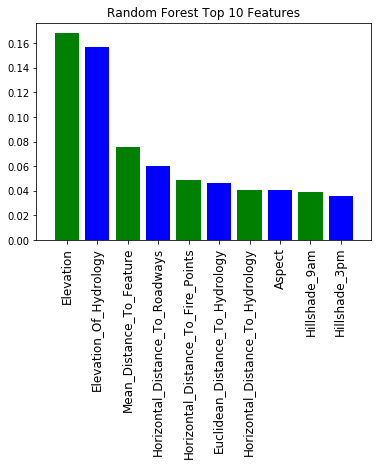

In [18]:
# Generate Initial RF and identify most important features
initialRF = RandomForestClassifier(n_estimators = 10)
initialRF.fit(e_X_train, e_y_train)
FeatImportance(initialRF, e_X_train, "Random Forest")

<a id=ensemble> </a>
### Ensemble Model


#### Approach
All machine learning models have their strengths and weaknesses. For example, most of the models we tested did well when classifying Cottonwood/Willow, but poorly for Lodgepole Pine data points. One way to help mitigate this problem is to combine several models into an ensemble model. An ensemble model allows multiple individual models to predict a data point, and then uses the results from all of them to decide what the true label is. We had three models that performed well during training; the Random Forest model, the K Nearest Neighbors model, and the Gradient Boosted Decision Trees (XGBoost) model. We chose to use 'soft' voting, which uses the sum of the predicted probabilities across all of the models to decide on a final lable. This type of voting is very good when the models that are used in the ensemble excel at predicting different types of labels. By combining the three models, we can expect to improve our performance.

While identifying the best possible models for an ensemble, we also tested various additional models suchs as MLP Classifier, Ada Boost, Quadratic Discriminant Analysis and Gaussian Process Classifier using a gridseach for best possible hyper paramerts. We fount that none of the other model combinations could improve the KNN, Random Forest and XGBoost ensemble. The original code has been moved to helper functions to remove clutters.

In [19]:
clf2 = RandomForestClassifier(n_estimators = 10)
clf4 = KNeighborsClassifier(n_neighbors=3)
clf5 = XGBClassifier(max_depth=10, learning_rate=0.3, n_estimators=200, n_jobs=4)

eClf = VotingClassifier(
    estimators=[
        ('Randomforest', clf2), 
        ('3 Nearest Neighbors', clf4), 
        ('XGBoost', clf5)
    ], 
    voting='soft', 
    n_jobs=-1)

cross_validate_model(eClf, e_X_train, e_y_train, name='ensemble', verbose=True)



Model: ensemble, with 5 folds
			Spruce/Fir           | precision:  0.77 | recall:  0.81 | f1-score:  0.79 | 
			Lodgepole Pine       | precision:  0.71 | recall:  0.80 | f1-score:  0.75 | 
			Ponderosa Pine       | precision:  0.85 | recall:  0.90 | f1-score:  0.88 | 
			Cottonwood/Willow    | precision:  0.98 | recall:  0.94 | f1-score:  0.96 | 
			Aspen                | precision:  0.97 | recall:  0.90 | f1-score:  0.93 | 
			Douglas Fir          | precision:  0.91 | recall:  0.87 | f1-score:  0.89 | 
			Krummholz            | precision:  0.98 | recall:  0.94 | f1-score:  0.96 | 
			macro avg            | precision:  0.88 | recall:  0.88 | f1-score:  0.88 | 
			micro avg            | precision:  0.88 | recall:  0.88 | f1-score:  0.88 | 
			weighted avg         | precision:  0.89 | recall:  0.88 | f1-score:  0.88 | 



{'micro avg': {'precision': [0.8777533039647577,
   0.8750918442321822,
   0.8849687614847482,
   0.886438809261301,
   0.8856617647058823],
  'recall': [0.8777533039647577,
   0.8750918442321822,
   0.8849687614847482,
   0.886438809261301,
   0.8856617647058823],
  'f1-score': [0.8777533039647577,
   0.8750918442321822,
   0.8849687614847482,
   0.886438809261301,
   0.8856617647058822]},
 'macro avg': {'precision': [0.8774980412659626,
   0.874825754119527,
   0.8846689553350647,
   0.8861664956125594,
   0.8853079206610358],
  'recall': [0.8755690359897815,
   0.8722237734739643,
   0.8826690188533173,
   0.8838285278091725,
   0.8829760134680803],
  'f1-score': [0.8751540346987652,
   0.8716093259603956,
   0.8830143247421555,
   0.8843010579669726,
   0.8829197258599605]},
 'weighted avg': {'precision': [0.8850982492772986,
   0.88529829143655,
   0.8897038157871124,
   0.8915735748192952,
   0.8929966828634428],
  'recall': [0.8777533039647577,
   0.8750918442321822,
   0.884968

In [34]:
cross_validate_model(XGBClassifier(max_depth=10, learning_rate=0.3, n_estimators=200, n_jobs=4), e_X_train, e_y_train, name=f'Gradient Boosted Decision Trees (XGBoost)', verbose=True)

Model: Gradient Boosted Decision Trees (XGBoost), with 5 folds
			Spruce/Fir           | precision:  0.76 | recall:  0.80 | f1-score:  0.78 | 
			Lodgepole Pine       | precision:  0.71 | recall:  0.78 | f1-score:  0.74 | 
			Ponderosa Pine       | precision:  0.85 | recall:  0.88 | f1-score:  0.87 | 
			Cottonwood/Willow    | precision:  0.97 | recall:  0.95 | f1-score:  0.96 | 
			Aspen                | precision:  0.96 | recall:  0.90 | f1-score:  0.93 | 
			Douglas Fir          | precision:  0.90 | recall:  0.86 | f1-score:  0.88 | 
			Krummholz            | precision:  0.98 | recall:  0.94 | f1-score:  0.96 | 
			macro avg            | precision:  0.88 | recall:  0.87 | f1-score:  0.87 | 
			micro avg            | precision:  0.88 | recall:  0.88 | f1-score:  0.88 | 
			weighted avg         | precision:  0.88 | recall:  0.88 | f1-score:  0.88 | 



#### Results
We do see the improvement that we expected by combining the models. A few items to note, it that the ensemble is almost perfect when predicting Cottonwood/Willow, and had a remarkable improvement on Lodgepole Pine over even the XGBoost model. In cases where a given model is unsure about a data point, none of the predicted probabilities are very high, the other models can out vote it if they are more sure of the result. Ensemble models have diminishing returns though, meaning that adding more and more models will provide less and less addition benefit. Using our top 3 models appears to be a sweet spot in the number and quality of the models.

## Master Model Result List

In [20]:
with warnings.catch_warnings(record=False):
    test_model(LogisticRegression(), e_X_train, e_y_train, e_X_test, e_y_test, name="LogisticRegression")
    
    test_model(GaussianNB(), e_X_train, e_y_train, e_X_test, e_y_test, name="GaussianNB")
    
    test_model(KNeighborsClassifier(n_neighbors=3), e_X_train, e_y_train, e_X_test, e_y_test, name="3 Nearest Neighbors")
    
    test_model(LinearSVC(), e_X_train, e_y_train, e_X_test, e_y_test, name='linearSVC')
    
    test_model(RandomForestClassifier(n_estimators = 10), e_X_train, e_y_train, e_X_test, e_y_test, name='RandomForest')
    
    test_model(XGBClassifier(max_depth=10, learning_rate=0.3, n_estimators=200, n_jobs=4), e_X_train, e_y_train, e_X_test, e_y_test, name=f'Gradient Boosted Decision Trees (XGBoost)')
    
    test_model(eClf, e_X_train, e_y_train, e_X_test, e_y_test, name=f'Ensemble Model')
    

Model: LogisticRegression
		Final                | precision:  0.67 | recall:  0.66 | f1-score:  0.67 | 
Model: GaussianNB
		Final                | precision:  0.79 | recall:  0.62 | f1-score:  0.67 | 
Model: 3 Nearest Neighbors
		Final                | precision:  0.85 | recall:  0.84 | f1-score:  0.84 | 
Model: linearSVC
		Final                | precision:  0.82 | recall:  0.33 | f1-score:  0.42 | 
Model: RandomForest
		Final                | precision:  0.84 | recall:  0.84 | f1-score:  0.84 | 


KeyboardInterrupt: 

<a id="results"></a>
    
# Results

Need to work on this

### Error Analysis

Our final result, reached a precision, recall and F-score of 89%. When we see the results in a confusion matrix, we can see that we get a Jackard similarity score of .89 with a hamming loss of .11. We also notice that model has difficulty in classifying Spure/Fir and mixing it with Lodgepole Pine and vice-versa. Our model is also misclassifying Doglas Fir with Ponderosa Pine. We need to apply further data engineering to improve accuracy of the models. We can also try to find models that can classify these covers better and try to add them in the ensemble to improve our scores

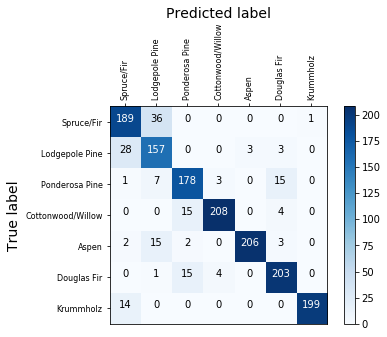

Jaccard similarity score: 0.89 with hamming loss of 0.11


In [21]:
eClf.fit(e_X_train, e_y_train)
pred_y = eClf.predict(e_X_test)
get_confusion_matrix(pred_y, e_y_test)
print("Jaccard similarity score: %0.2f with hamming loss of %0.2f"%(jaccard_similarity_score(e_y_test,pred_y),hamming_loss(e_y_test,pred_y)))

<a id="conclusion"></a>

# Conclusion

#### Most Important Features 
The story that came out of the data was, in many ways, were quire counter intuitive. At the end of the analysis, the key components.
    1. Elevation (0.162398)
    2. Elevation_Of_Hydrology (0.151600)
    3. Mean_Distance_To_Feature (0.070873)
    4. Horizontal_Distance_To_Roadways (0.070431)
    5. Euclidean_Distance_To_Hydrology (0.057154)
    6. Horizontal_Distance_To_Fire_Points (0.051782)
    7. Hillshade_Noon (0.036232)
    8. Aspect (0.035743)
    9. Hillshade_9am (0.035738)
    10. Vertical_Distance_To_Hydrology (0.035153)
We were surpised that all the details of the soil type, at the end, did not really matter for this dataset. It is true in this case may not be universally true.

#### What can be done to improve further 
    1. More Data Engineering
    Due to the time restrictions and large number of variables, we were not able to extract all possibly new features that could improve the models further.
    2. Mode model and parameter testing in ensemble
    The processing power needed to run complex combination of models, parameters take very long time to proces. and hence we could not test all possible combinations.
    


<a id="annexes"></a>
    
# Annexes

<a id="annexA"></a>

## Annex A: Exploratory Data Analysis

This appendix contains some of our exploratory data analysis. This includes the code used to generate the 4-number summaries of our data reflected in the [_About the Data_](#aboutTheData) and other summaries. The most informative portions are replicated in the main body of the report.

After we load the data from the source file, we examine the basic characteristics of the dataset.
  1. We expect to see all of the features discussed above represented in our column names
  1. As there is no separate dataset containing the labels for our observations, we would expect to see the 'Cover_Type' variable in our data
  1. We would expect to see a shape of (15120, 55) - the 54 features plus our label column

In [21]:
print(f'Columns: {full_data.columns}')
print(f'Shape: {full_data.shape}')

Columns: Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'So

We take a look at the first several observations to get a sense for the nature of the data.

In [22]:
full_features.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
Id,,,,,,,,,,,,,,,,,,,,,
1,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,0
2,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,0
3,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,0
4,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,0
5,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,0


We'll also want to get a high-level summary of each of our features.

In [23]:
# Small function to give us a bird's-eye summary of the data
def five_num_summary(df, column):
    print(f'Column: {column:<35} | ' +
          f'Max value: {np.max(df[column]):>6} | ' + 
          f'Min value: {np.min(df[column]):>7.2f} | ' +
          f'Mean: {np.mean(df[column]):>7.2f} | ' +
          f'Median: {np.median(df[column]):>7.2f}')

for col_name in full_features.columns:
    five_num_summary(full_features, col_name)

Column: Elevation                           | Max value:   3849 | Min value: 1863.00 | Mean: 2749.32 | Median: 2752.00
Column: Aspect                              | Max value:    360 | Min value:    0.00 | Mean:  156.68 | Median:  126.00
Column: Slope                               | Max value:     52 | Min value:    0.00 | Mean:   16.50 | Median:   15.00
Column: Horizontal_Distance_To_Hydrology    | Max value:   1343 | Min value:    0.00 | Mean:  227.20 | Median:  180.00
Column: Vertical_Distance_To_Hydrology      | Max value:    554 | Min value: -146.00 | Mean:   51.08 | Median:   32.00
Column: Horizontal_Distance_To_Roadways     | Max value:   6890 | Min value:    0.00 | Mean: 1714.02 | Median: 1316.00
Column: Hillshade_9am                       | Max value:    254 | Min value:    0.00 | Mean:  212.70 | Median:  220.00
Column: Hillshade_Noon                      | Max value:    254 | Min value:   99.00 | Mean:  218.97 | Median:  223.00
Column: Hillshade_3pm                       | Ma

### Checking Label Imbalance

It would be useful for us to understand whether we have an imbalanced dataset (i.e., one where certain labels/categories are overrepresented relative to others.) Here we'll quickly describe our training and test labels and just make sure our classes are balanced. We can do this both graphically and numerically.

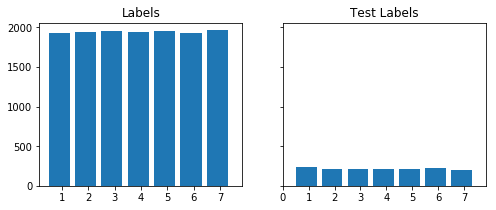

In [24]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,3), sharey=True)
bins = np.arange(8) + 0.5
ax1.hist(y_train, bins, width = 0.8)
ax1.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax1.set_title('Labels')
ax2.hist(y_test, bins, width = 0.8)
ax2.set_title('Test Labels')
plt.xticks(range(8))
plt.show()

In [25]:
print(stats.describe(full_labels))
print(stats.describe(y_test))
for i in range(0, 8):
        print(f'i = {i}: Train Ct: {(full_labels==i).sum():>5} | Test Ct: {(y_test==i).sum():>5}')

DescribeResult(nobs=15120, minmax=(1, 7), mean=4.0, variance=4.000264567762418, skewness=0.0, kurtosis=-1.25)
DescribeResult(nobs=1512, minmax=(1, 7), mean=3.947751322751323, variance=4.034991631037296, skewness=0.010853316785871835, kurtosis=-1.2670058892892788)
i = 0: Train Ct:     0 | Test Ct:     0
i = 1: Train Ct:  2160 | Test Ct:   234
i = 2: Train Ct:  2160 | Test Ct:   216
i = 3: Train Ct:  2160 | Test Ct:   210
i = 4: Train Ct:  2160 | Test Ct:   215
i = 5: Train Ct:  2160 | Test Ct:   209
i = 6: Train Ct:  2160 | Test Ct:   228
i = 7: Train Ct:  2160 | Test Ct:   200


It appears that our classes are quite well-balanced in both our training data and the test data.

This is good both because we will not need to deliberately compensate for imbalances and because our model will be unable to achieve reasonable performance simply by guessing the modal category. (Doing so would give accuracy on the training set of 1741/12096 = 0.145, and then accuracy on the test set of 411/3024 = 0.136.)

One thing of note is that the `Soil_Type7` and `Soil_Type15` are never true, so this feature tells us nothing.  These features should be removed before any modeling is done.

In [26]:
bins = np.arange(0, 360, 10)
cut = [0, 45, 90, 135, 180, 225, 270, 315, 360]

print(bins)
pd.cut(bins, cut)

[  0  10  20  30  40  50  60  70  80  90 100 110 120 130 140 150 160 170
 180 190 200 210 220 230 240 250 260 270 280 290 300 310 320 330 340 350]


[NaN, (0, 45], (0, 45], (0, 45], (0, 45], ..., (270, 315], (315, 360], (315, 360], (315, 360], (315, 360]]
Length: 36
Categories (8, interval[int64]): [(0, 45] < (45, 90] < (90, 135] < (135, 180] < (180, 225] < (225, 270] < (270, 315] < (315, 360]]

In [27]:
full_data['Total_Hillshade'] = full_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].sum(axis=1)
full_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm','Total_Hillshade']].head(20)

,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Total_Hillshade
Id,,,,
1,221,232,148,601
2,220,235,151,606
3,234,238,135,607
4,238,238,122,598
5,220,234,150,604
6,230,237,140,607
7,222,225,138,585
8,222,230,144,596
9,223,221,133,577


In [28]:
## Make 3D scatterplot to explore water, elevation, and hillshade concurrently

%matplotlib qt
from mpl_toolkits.mplot3d import Axes3D

sparsifier = np.random.randint(0, full_features.shape[0], 5000)

sparsified = full_features.iloc[sparsifier,:]
sparse_labels = full_labels.iloc[sparsifier]
# print(f'Length of sparsified dataset\n: {sparsified}')

full_features['Euclidean_distance_to_water'] = np.sqrt(full_features['Horizontal_Distance_To_Hydrology']**2 + full_features['Vertical_Distance_To_Hydrology']**2)
dist_to_water = sparsified['Euclidean_distance_to_water']
altitude = sparsified['Elevation']
hillshade = sparsified['Hillshade_3pm']
color_dict = {1: '#A7C6ED', 2: '#BA0C2F', 3: '#651D32', 4: '#8C8985',
              5: '#212721', 6: '#002F6C', 7: '#FFC000'}
coloration = [color_dict[x] for x in sparse_labels]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(hillshade, dist_to_water, altitude, color=coloration, alpha=0.6)
# ax.title('Forest cover categorization\nby distance to water and hillshade')
ax.view_init(30, 115)
# mouse_init(rotate_btn=1, zoom_btn=3)
plt.show()

KeyError: 'Euclidean_distance_to_water'